In [158]:
import pandas as pd
import tensorflow as tf
import numpy as np
from zipfile import ZipFile

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, Flatten, Conv2D, MaxPool2D
from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


In [159]:
#extracting zip file
data_path = 'archive.zip'
with ZipFile(data_path, 'r') as zip: 
	zip.extractall() 
	print('The data set has been extracted.') 


The data set has been extracted.


In [160]:
#obtaining the filename for each jpg
def get_jpg_filenames(folder_path):
    jpg_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".jpg")]
    return jpg_files

In [161]:
#getting the image filename and assigning a label to each one
black_hole_path = 'BlackHole/BlackHole'
galaxy_path = 'Galaxy/Galaxy'
black_hole_files = get_jpg_filenames(black_hole_path)
galaxy_files = get_jpg_filenames(galaxy_path)

black_hole_labels = [0]*len(black_hole_files)   #black holes have a label of zero
galaxy_labels = [1] * len(galaxy_files)         #galaxies have a label of one

In [162]:
#converting data to a pandas dataframe and creating train, test split
df_hole = pd.DataFrame({"file_name": black_hole_files, "label": black_hole_labels})
df_galaxy = pd.DataFrame({"file_name": galaxy_files, "label": galaxy_labels})
df = pd.concat([df_hole, df_galaxy], ignore_index=True)
df['label'] = df['label'].astype(str)

x_train, x_test, y_train, y_test = train_test_split(df['file_name'], df['label'], test_size=0.2, random_state=42)
df_train = pd.DataFrame({'image_file': x_train, 'label': y_train})
df_test = pd.DataFrame({'image_file': x_test, 'label': y_test})

In [163]:
#checking dataset balance
print(df)
print(f'# of black hole images = {len(black_hole_files)}')
print(f'# of galaxy images = {len(galaxy_files)}')


                            file_name label
0    BlackHole/BlackHole/hole_027.jpg     0
1    BlackHole/BlackHole/hole_219.jpg     0
2    BlackHole/BlackHole/hole_153.jpg     0
3    BlackHole/BlackHole/hole_147.jpg     0
4    BlackHole/BlackHole/hole_190.jpg     0
..                                ...   ...
395      Galaxy/Galaxy/galaxy_019.jpg     1
396      Galaxy/Galaxy/galaxy_192.jpg     1
397      Galaxy/Galaxy/galaxy_145.jpg     1
398      Galaxy/Galaxy/galaxy_151.jpg     1
399      Galaxy/Galaxy/galaxy_179.jpg     1

[400 rows x 2 columns]
# of black hole images = 200
# of galaxy images = 200


In [164]:
datagen = ImageDataGenerator(rescale=1./255)

# Flow images from DataFrame
train_datagen = datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col= "image_file",
    y_col= "label",
    target_size=(244, 244),
    batch_size=32,
    class_mode= "binary",  # Use 'raw' for regression, 'binary' for binary classification, or 'categorical' for multiclass classification
    subset= 'training',
    seed=42
)

test_datagen = datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col = "image_file",
    y_col = "label",
    target_size = (244, 244),
    batch_size = 32,
    class_mode = "binary",
)

Found 320 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.


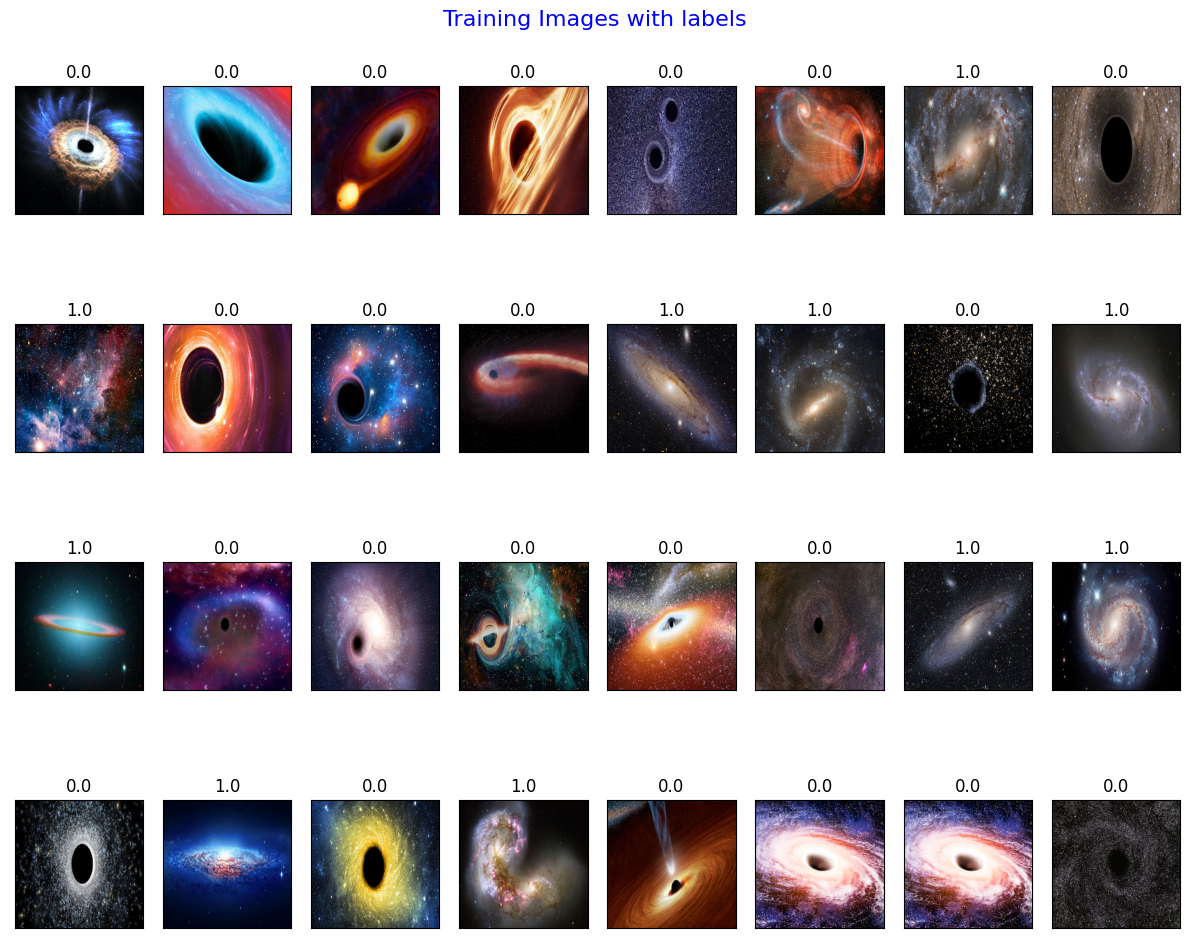

In [165]:
# visualisation of datasets
features, target = next(train_datagen)

# plot 32 images
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
	# remove axies
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Training Images with labels',  y=0.9,fontsize=16, color='b')
    plt.tight_layout()

In [166]:
#creating sequential model
model = keras.Sequential([ 
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(244, 244, 3)), 
    layers.MaxPooling2D(2, 2), 
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPooling2D(2, 2), 
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPooling2D(2, 2), 
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPooling2D(2, 2), 
  
    layers.Flatten(), 
    layers.Dense(512, activation='relu'), 
    layers.BatchNormalization(), 
    layers.Dense(512, activation='relu'), 
    layers.Dropout(0.1), 
    layers.BatchNormalization(), 
    layers.Dense(512, activation='relu'), 
    layers.Dropout(0.2), 
    layers.BatchNormalization(), 
    layers.Dense(1, activation='sigmoid') 
]) 

model.summary()
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics='accuracy')
history = model.fit(train_datagen, epochs=10, validation_data=test_datagen) 


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 121, 121, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 119, 119, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 59, 59, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 222784)            0         
                                                                 
 dense_16 (Dense)            (None, 512)              

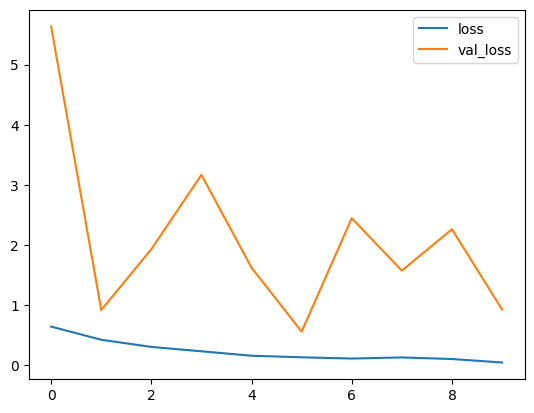

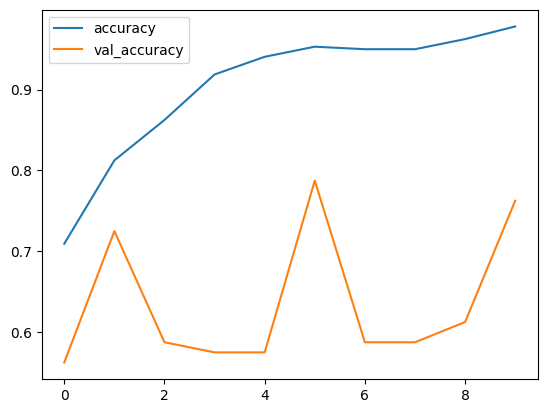

In [167]:
history_df = pd.DataFrame(history.history) 
history_df.loc[:, ['loss', 'val_loss']].plot() 
history_df.loc[:, ['accuracy', 'val_accuracy']].plot() 
plt.show() 


1/1 [==============================] - 1s 529ms/step


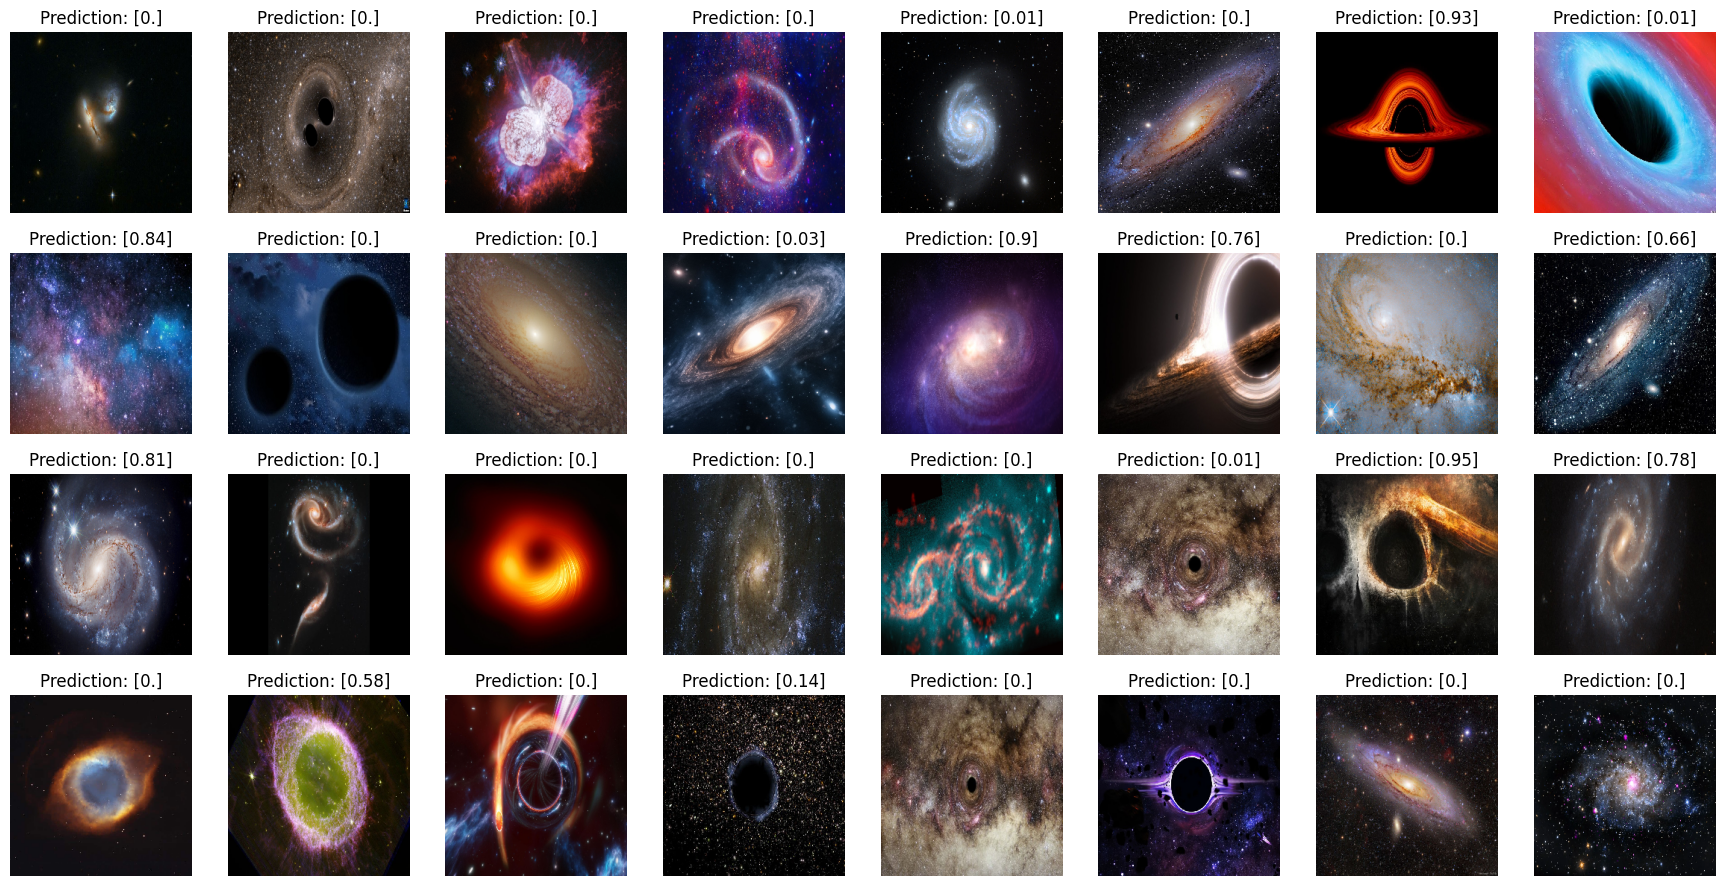

In [168]:
model.evaluate(test_datagen)
pred_probabilites = model.predict(features)

# Visualisation of datasets
features, target = next(test_datagen)
# Create a grid of images
fig, axes = plt.subplots(4, 8, figsize=(22, 11))

 # Display each image in the grid
for i, ax in enumerate(axes.flatten()):
    ax.imshow(features[i])
    ax.set_title(f'Prediction: {np.round(pred_probabilites[i], 2)}')
    ax.axis('off')

plt.show()

In [169]:
pred_probabilites
features[0][0][0]


array([0.        , 0.01568628, 0.01176471], dtype=float32)

1/1 [==============================] - 0s 260ms/step
[[0.]]
Black Hole


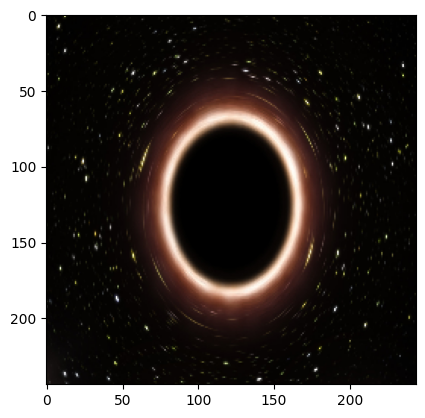

In [170]:
#Input image 
test_image = image.load_img('black_hole_test_image.jpeg',target_size=(244,244)) 

#For show image 
plt.imshow(test_image) 
test_image = image.img_to_array(test_image) 
test_image = np.expand_dims(test_image,axis=0) 

# Result array 
result = model.predict(test_image) 
print(result)
#Mapping result array with the main name list 

if(result>=0.5): 
    print("Galaxy") 
else: 
    print("Black Hole")


1/1 [==============================] - 0s 75ms/step
Black Hole


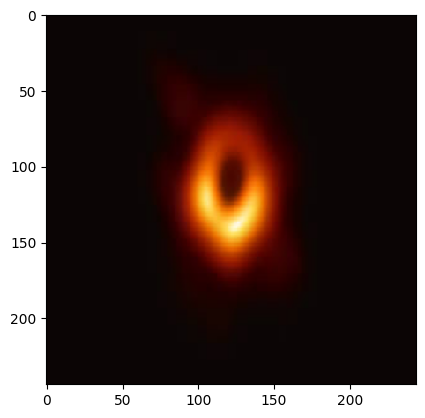

In [171]:
#Input image 
test_image = image.load_img('black_hole_test_image2.jpeg',target_size=(244,244)) 

#For show image 
plt.imshow(test_image) 
test_image = image.img_to_array(test_image) 
test_image = np.expand_dims(test_image,axis=0) 

# Result array 
result = model.predict(test_image) 

#Mapping result array with the main name list 

if(result>=0.5): 
    print("Galaxy") 
else: 
    print("Black Hole")


1/1 [==============================] - 0s 74ms/step
[[0.]]
Black Hole


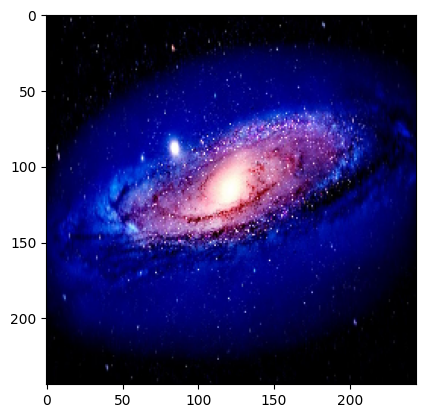

In [172]:
#Input image 
test_image = image.load_img('galaxy_test_image.jpeg',target_size=(244,244)) 

#For show image 
plt.imshow(test_image) 
test_image = image.img_to_array(test_image) 
test_image = np.expand_dims(test_image,axis=0) 

# Result array 
result = model.predict(test_image) 
print(result)
#Mapping result array with the main name list 

if(result>=0.5): 
    print("Galaxy") 
else: 
    print("Black Hole")


1/1 [==============================] - 0s 74ms/step
[[0.]]
Black Hole


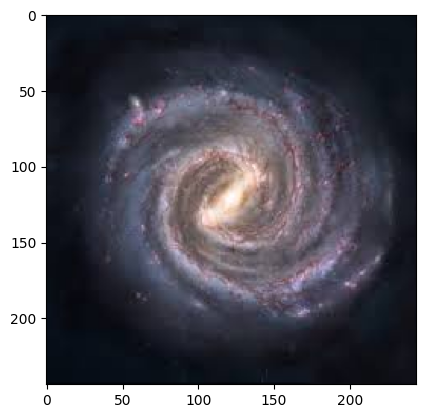

In [173]:
#Input image 
test_image = image.load_img('galaxy_test_image2.jpeg',target_size=(244,244)) 

#For show image 
plt.imshow(test_image) 
test_image = image.img_to_array(test_image) 
test_image = np.expand_dims(test_image,axis=0) 

# Result array 
result = model.predict(test_image) 
print(result)
#Mapping result array with the main name list 

if(result>=0.5): 
    print("Galaxy") 
else: 
    print("Black Hole")